<a href="https://colab.research.google.com/github/musicjae/intro_to_python/blob/master/Pytorch/NLP/2_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고: https://github.com/rguthrie3/DeepLearningForNLPInPytorch/blob/master/Deep%20Learning%20for%20Natural%20Language%20Processing%20with%20Pytorch.ipynb

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt


# Word Embedding  
  
- word embeddings are a representation of the semantics of a word, efficiently encoding semantic information that might be relevant to the task at hand.  
  
-  embeddings are stored as a $|V| \times D$ matrix, where $D$ is the dimensionality of the embeddings, such that the word assigned index $i$ has its embedding stored in the $i$'th row of the matrix

# Language Model  
  
- Recall that in an n-gram language model, given a sequence of words $w$, we want to compute$$ P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} ) $$Where $w_i$ is the ith word of the sequence

text: 신문 기사 [“제2의 비틀즈 아닌 최초의 BTS”…美음악매체 선정 ‘올해의 밴드‘]('https://www.seoul.co.kr/news/newsView.php?id=20201210500045')

## Data Load

In [6]:
text = """그룹 방탄소년단(BTS)이 미국의 음악 매체 컨시퀀스 오브 사운드(Consequence of Sound)가 꼽은 ‘올해의 밴드’(2020 Band of the Year)에 이름을 올렸다.

컨시퀀스 오브 사운드는 8일(현지시간) 공식 홈페이지를 통해 방탄소년단을 ‘올해의 밴드’로 선정했다고 밝혔다. 이 매체는 매년 미국 내 뉴스 및 음악, 영화, TV 중심의 온라인 매체에서 주목을 받은 올해의 아티스트와 밴드를 꼽는다.

이 매체는 한국 가수 최초로 ‘다이너마이트’(Dynamite)와 ‘라이프 고즈 온’(Life Goes On)으로 빌보드 메인 싱글 차트 ‘핫 100’에서 연속으로 정상에 오른 점, 빌보드 역사상 처음으로 ‘핫 100’과 ‘빌보드 200’에 동시 1위로 신규 진입한 점, 케이팝 최초 그래미 어워즈 후보 선정 등 올해 이룬 성과들을 조명했다.

이어 “방탄소년단이 불확실성과 상실감으로 가득했던 한 해에 행복과 희망의 메시지를 가져왔다”며 “이들은 ‘제2의 비틀스’가 아닌 ‘최초의 방탄소년단’일지 모른다”고 평했다.

앞서 펄 잼, 아케이드 파이어, 더 루츠, 툴 등을 ‘올해의 밴드’로 선정했던 컨시퀀스 오브 사운드는 “공통점은 진실성, 인지도, 끈기, 진정성, 음악에 대한 헌신”이라며 “방탄소년단은 이 모든 기준을 충족하고도 남는다”고 덧붙였다.""".split(" ")

### Trigrams 만들기

In [32]:
trigrams = [([text[i], text[i+1]], text[i+2]) for i in range(len(text)-2)]
print(trigrams[:3])
print(trigrams[50:53])
print(len(trigrams))

[(['그룹', '방탄소년단(BTS)이'], '미국의'), (['방탄소년단(BTS)이', '미국의'], '음악'), (['미국의', '음악'], '매체')]
[(['한국', '가수'], '최초로'), (['가수', '최초로'], '‘다이너마이트’(Dynamite)와'), (['최초로', '‘다이너마이트’(Dynamite)와'], '‘라이프')]
137


### word to index

In [85]:
vocab = set(text)
w2i = {word:idx for idx,word in enumerate(vocab)}
i2w = {idx:word for idx,word in enumerate(vocab)}
print(f'단어 집합 사이즈: {len(w2i)}')

단어 집합 사이즈: 126


## LM model

In [60]:
VOCAB_SIZE = len(vocab)
CONTEXT_SIZE = 2
EMBEDDING_DIM = 16


class trigram_LM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(trigram_LM, self).__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim*context_size, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embed = self.emb(inputs).view((1,-1)) # Flattening
        out = F.tanh(self.linear(embed))
        out = F.log_softmax(self.linear2(out))

        return out

model = trigram_LM(VOCAB_SIZE,EMBEDDING_DIM,CONTEXT_SIZE)
print(model)

trigram_LM(
  (emb): Embedding(126, 16)
  (linear): Linear(in_features=32, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=126, bias=True)
)


In [57]:
for param in model.parameters():
    print(param.shape)

torch.Size([126, 16])
torch.Size([128, 80])
torch.Size([128])
torch.Size([126, 128])
torch.Size([126])


In [58]:
for layer_name, layer in model.named_modules():
    print(layer_name)


emb
linear
linear2


## Training

In [67]:
losses = []
epochs = []
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

print('Learning...........................')
for epoch in range(500):
    total_loss = torch.Tensor([0]) # init loss
    
    for ctx, target in trigrams:

        # 1. input 준비
        context_idx = list(map(lambda w: w2i[w], ctx))
        context_var = autograd.Variable(torch.LongTensor(context_idx))

        model.zero_grad() # clear grad
        predictions = model(context_var)
        loss = loss_fn(predictions, torch.autograd.Variable(torch.LongTensor([w2i[target]])))

        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss.item())
    if epoch % 10 == 0:
        epochs.append(epoch)
        print(f'Epoch: {epoch}')
        print(f'  loss: {total_loss.item()}')


Learning...........................
Epoch: 0
  loss: 40.84033203125


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 10
  loss: 37.84450149536133
Epoch: 20
  loss: 35.249210357666016
Epoch: 30
  loss: 32.98527526855469
Epoch: 40
  loss: 30.997621536254883
Epoch: 50
  loss: 29.24197769165039
Epoch: 60
  loss: 27.682510375976562
Epoch: 70
  loss: 26.29001235961914
Epoch: 80
  loss: 25.040523529052734
Epoch: 90
  loss: 23.91423797607422
Epoch: 100
  loss: 22.894668579101562
Epoch: 110
  loss: 21.968074798583984
Epoch: 120
  loss: 21.122848510742188
Epoch: 130
  loss: 20.349199295043945
Epoch: 140
  loss: 19.638765335083008
Epoch: 150
  loss: 18.984420776367188
Epoch: 160
  loss: 18.380037307739258
Epoch: 170
  loss: 17.820302963256836
Epoch: 180
  loss: 17.300628662109375
Epoch: 190
  loss: 16.817020416259766
Epoch: 200
  loss: 16.365962982177734
Epoch: 210
  loss: 15.9443998336792
Epoch: 220
  loss: 15.549616813659668
Epoch: 230
  loss: 15.179221153259277
Epoch: 240
  loss: 14.831095695495605
Epoch: 250
  loss: 14.503337860107422
Epoch: 260
  loss: 14.194275856018066
Epoch: 270
  loss: 13.902393

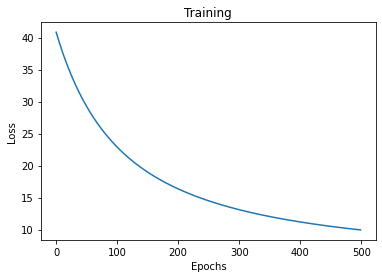

In [72]:
plt.title('Training')
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [83]:
for i in model.parameters():
    print(i.shape)

torch.Size([126, 16])
torch.Size([128, 32])
torch.Size([128])
torch.Size([126, 128])
torch.Size([126])
